In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
from skbio.stats.distance import mantel
import matplotlib.pyplot as plt
import numpy as np

In [39]:
df1 = pd.read_csv("dataset/Dortmund_features.csv", index_col=0)
df2 = pd.read_csv("dataset/Lemon_features.csv", index_col=0)
df1.shape, df2.shape


((600, 147), (190, 147))

In [40]:
# order features alphabetically & keep only common features (they are all the same)
common = sorted(set(df1.columns) & set(df2.columns))
df1_common = df1[common]
df2_common = df2[common]
df1.columns, df2.columns 

(Index(['nl_rqa mean diag length', 'kurtosis_amp_theta', 'lt_delta',
        'envelope_mean_alpha', 'nl_correlation dim', 'kurtosis_amp_alpha',
        'mod_index_theta-gamma', 'nl_rqa rte', 'nl_higuchi fractal dim',
        'acw50',
        ...
        'plv_ns_theta', 'plv_betw-cent_alpha', 'plv_local-eff_alpha',
        'coh_global-eff_beta', 'dfa_alpha', 'range_cv_gamma',
        'wpli_clust-coef_alpha', 'range_cv_theta', 'osc_delta', 'dfa_beta'],
       dtype='object', length=147),
 Index(['range_assym_alpha', 'coh_global-eff_theta', 'skewness_amp_alpha',
        'skewness_amp_delta', 'range_cv_alpha', 'wpli_betw-cent_beta',
        'spec_ent_alpha', 'nl_rqa mean diag length', 'kurtosis_amp_theta',
        'plv_betw-cent_theta',
        ...
        'lt_gamma', 'total_power_beta', 'wpli_clust-coef_alpha',
        'mod_index_theta-alpha', 'mod_index_theta-gamma', 'range_cv_theta',
        'rel_amp_delta', 'skewness_amp_gamma', 'osc_delta', 'dfa_beta'],
       dtype='object', length=1

In [41]:
# correlation matrices
corr1 = df1_common.corr().values
corr2 = df2_common.corr().values    

Correlation between correlation matrices: 0.8385


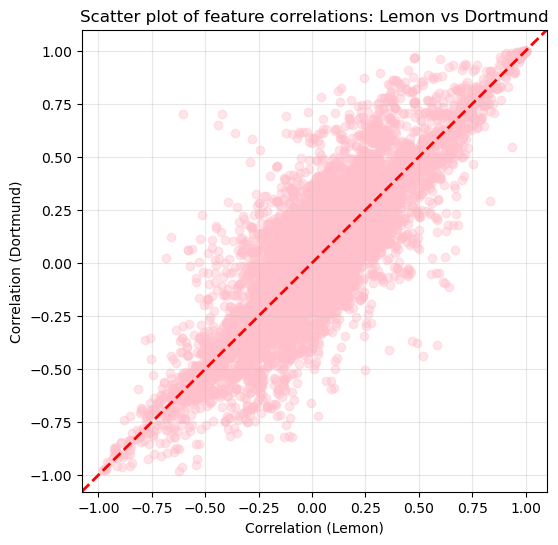

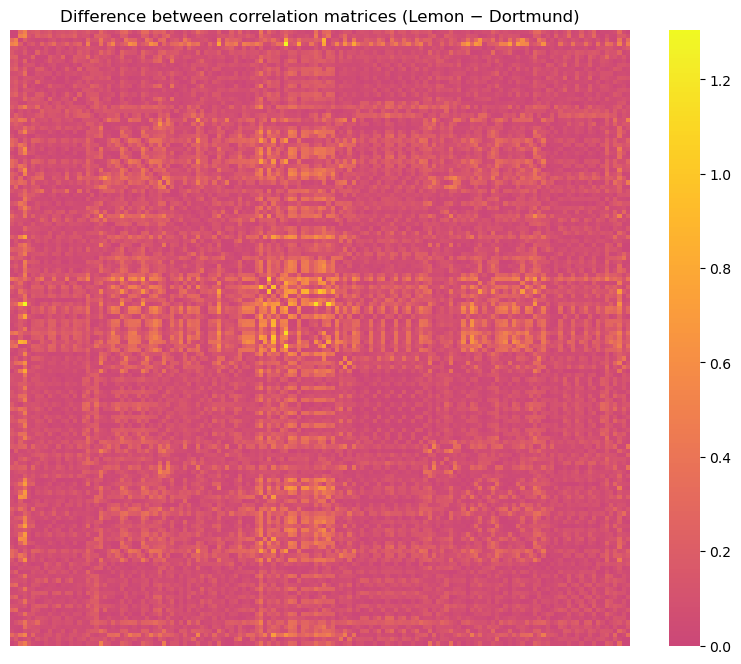

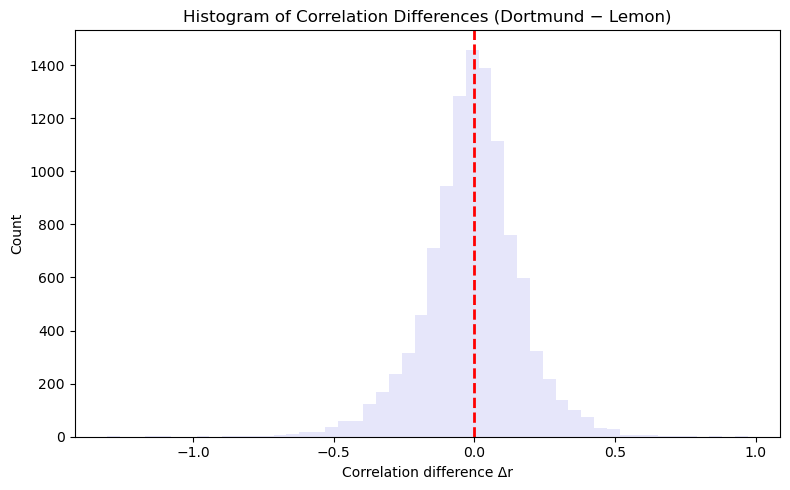

In [68]:
# MATRIX CORRELATION: very high
idx = np.triu_indices_from(corr1, k=1)
vec1 = corr1[idx]
vec2 = corr2[idx]

matrix_corr, _ = pearsonr(vec1, vec2)
print(f"Correlation between correlation matrices: {matrix_corr:.4f}")

# scatter plot of correlations
plt.figure(figsize=(6, 6))
plt.scatter(vec1, vec2, alpha=0.4, color='pink')
plt.xlabel("Correlation (Lemon)")
plt.ylabel("Correlation (Dortmund)")
plt.title("Scatter plot of feature correlations: Lemon vs Dortmund")
plt.axline((0, 0), (1, 1), color='red', linestyle='--', linewidth=2)  # identity line
plt.grid(True, alpha=0.3)
plt.show()

# heatmap of correlation matrices 
# -> very noisy and not very informative (correlations matrices are basically the same)
diff_mat = abs(corr2 - corr1)
plt.figure(figsize=(10, 8))
sns.heatmap(diff_mat, 
            cmap="plasma", 
            center=0, 
            xticklabels=False, 
            yticklabels=False)
plt.title("Difference between correlation matrices (Lemon − Dortmund)")
plt.show()

# histogram of differences
diff = vec1 - vec2
plt.figure(figsize=(8,5))
plt.hist(diff, bins=50, color = 'lavender')
plt.axvline(0, color='red', linewidth=2, linestyle='--')
plt.title("Histogram of Correlation Differences (Dortmund − Lemon)")
plt.xlabel("Correlation difference Δr")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [43]:
# MANTEL TEST: same as matrix correlation )
# convert correlation matrices to distance matrices (1 - corr)
dis1 = 1 - corr2
dis2 = 1 - corr1

mantel_r, mantel_p, _ = mantel(dis1, dis2, method='pearson', permutations=999)
print(f"Mantel r: {mantel_r:.4f}, p-value: {mantel_p:.4f}")


Mantel r: 0.8385, p-value: 0.0010


In [44]:
# RV COEFFICIENT using covariance (require matching features)
# RV treats rows = features, columns = subjects
X = df1_common.values.T # size = (147, 600)
Y = df2_common.values.T # size = (147, 190)

# Center matrices
Xc = X - X.mean(axis=1, keepdims=True)
Yc = Y - Y.mean(axis=1, keepdims=True)
print(Xc.shape, Yc.shape)

# Compute RV
numerator = np.trace((Xc @ Xc.T) @ (Yc @ Yc.T))
denominator = np.sqrt(np.trace((Xc @ Xc.T) @ (Xc @ Xc.T)) * np.trace((Yc @ Yc.T) @ (Yc @ Yc.T)))
RV = numerator / denominator
print(f"RV: {RV:.4f}")

(147, 600) (147, 190)
RV: 0.9881


The correlation structure is very strong between the two datasets.
Matrix correlation: 0.84 -> the features that are correlated in Dortmund are also correlateed in Lemon. The internal structure of correlation is very similar.
Mantel test: r=0.8385, p=0.0010 -> Mantel test takes two distance matrices (1-correlation) and computes correlation between these. It also evaluates if the value obtained is significant through permutations. We obtain the same strong correaltion and a p-value of 0.001 (very strong), meaning that it's very improbable that this strong correlation is random.
RV: 0.9881, it means the multvariate geometry of the features is almost identicals, the datasets are organized in the same way.

We can conclude that the two datasets have features relationship that are very robust, the cluster we find in one dataset will make sense in the other as well & we can compare/unire datasets in modo affidabile.